# PyG Implementation of MeshGraphNets

In this Colab, we provide all of the code discussed in our Medium blog post, Learning Mesh-Based Flow Simulations on Graph Networks, by Isaac Ju, Robert Lupoiu, and Rayan Kanfar, as part of the Stanford CS224W course project.

NOTE: TO ACCESS THE DATASETS AND FILES ACCOMPANYING THIS COLAB, PLEASE FOLLOW THE FOLLOWING LINK: https://drive.google.com/drive/folders/12QaYm2Y6H4UJ0dit9us4cfN7HelpLXvD?usp=sharing

This code is based on the paper by T. Pfaff et al., Learning Mesh-Based Simulation with Graph Networks (2021) ICLR. DeepMind provides their codebase for this project, but it is written in TensorFlow. Here, we write the code from the ground up based on the description given in the original paper in PyG, a framework for building graph neural networks (GNNs) in PyTorch, which is much more suitable for quickly iterating and experimenting with GNNs. The original codebase provided by DeepMind is available here: https://github.com/deepmind/deepmind-research/tree/master/meshgraphnets.

In this notebook, the task is to build, train, and evaluate the performance of MeshGraphNets built using PyG. This is done in an instructive manner. At a high level, in this notebook we first either pre-process the CylinderFlow dataset into a PyG-workable format or import an already pre-processed PyG dataset, we build MeshGraphNets using the PyG framework, and we then use a training and testing pipeline that we build to test the performance of MeshGraphNets on several datasets. Recall from the Medium article that the goal is to learn how to predict the acceleration of a fluid on a mesh domain at the nodes of a GNN. The results are then visualized at the end.

**Note:** Make sure to sequentially run the cells in each section so that intermediate variables and dependency imports carry over. The single exception is the data pre-processing code. This can be skipped and the alread processed data we provided can be used instead.

We hope that you will find this code useful in your learning, research, or work. Thank you for taking the time to look through!

# Acessing Pre-Processed Datasets

In order to access the preprocessed datasets, we will need to implement a little Google Colab workaround in order to access them without downloading them to your own Drive. We will mount the directories used in this Colab to this instance. If you're not sure how to do that, please follow these steps:

1.   Go to the root directory in which this file is located (named MeshGraphNets_PyG)
2.   Right-click on the ./datasets folder and select "Add shortcut to Drive"
3.   Create a shortcut of ./datasets ./animations ./best_models in "My Drive"
4.   Run the cell below and follow the prompts in the pop-up windows. Allow Google Colab to access your Drive so that you it can view the shortcut that you just created.

After completing the steps listed above, you will have access to all of the datasets in the ./datasets folder!

Next, let's install some dependencies into our Google Colab instance that we will use for loading data and training.

Now, let's import all of the dependencies that we need for importing and processing data, as well as building, training, and evaluating our model!

In [1]:
import torch
import random
import pandas as pd
import torch_scatter
import torch.nn as nn
from torch.nn import Linear, Sequential, LayerNorm, ReLU
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.data import DataLoader

import numpy as np
import time
import torch.optim as optim
from tqdm import trange
import pandas as pd
import copy
import matplotlib.pyplot as plt

import os
import numpy as np
import torch
import h5py
import tensorflow.compat.v1 as tf
import functools
import json
from torch_geometric.data import Data
import enum

import sys
sys.path.append('../src')
from ice_graph.ice_graph import Ice_graph





2024-04-22 16:24:35.949161: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-22 16:24:36.389982: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 16:24:37.501162: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Preparing and Loading the Dataset

Here we show how we processed the dataset to prepare it to work with PyG. We also provided some pre-processed datasets that you can use directly. We first converted these to h5 format to make the data easier to handle with PyTorch and NumPy. This is then processed below.

First, we need to define the root directory and the directories of the datasets, where to save the checkpoint, and where to store animations. The defaults given below will work if you followed the instructions in the first cell above.

**Data Pre-Processing Code**

We begin by first importing all of the needed dependencies for data processing

#Utility functions

Here we define the functions that are needed for assisting in data processing.

triangle_to_edges:  decomposes 2D triangular meshes to edges and returns the undirected graph nodes.

NodeType: is subclass of enum with unique and unchanging integer valued attributes over instances in order to make sure values are unchanged

In [2]:
def triangles_to_edges(faces):
    """Computes mesh edges from triangles."""
    # collect edges from triangles
    faces = torch.tensor(np.array(faces))
    edges = torch.cat((faces[:, 0:2],
                       faces[:, 1:3],
                       torch.stack((faces[:, 2], faces[:, 0]), dim=1)), dim=0)
    
    # those edges are sometimes duplicated (within the mesh) and sometimes
    # single (at the mesh boundary).
    # sort & pack edges as single torch.int64
    receivers = torch.min(edges, dim=1)[0]
    senders = torch.max(edges, dim=1)[0]
    packed_edges = torch.stack((senders, receivers), dim=1).to(torch.int64)
    # remove duplicates and unpack
    unique_edges = torch.unique(packed_edges, dim=0)
    senders, receivers = unique_edges.unbind(1)
    
    # create two-way connectivity
    return torch.stack((torch.cat((senders, receivers), dim=0),
            torch.cat((receivers, senders), dim=0)))


In [8]:

#load files
files = sorted(os.listdir('../../week_data'))[48:100]
file_graphs = []
for file in files:
    try:
        file_graphs.append(dict(np.load('../../week_data/' + file)))
    except:
        print(file)

len(files),len(file_graphs)
for key,i in file_graphs[0].items():
    print(key,i.shape)

nextsim = Ice_graph(
    file_graphs,
    vertex_element_features =
        ['M_wind_x',
        'M_wind_y',
        'M_ocean_x',
        'M_ocean_y',
        'M_VT_x',
        'M_VT_y',
        'x',
        'y']
)

field_20230102T170000Z.npz
Damage (137518,)
Concentration (137518,)
Thickness (137518,)
Sigma_0 (137518,)
Sigma_1 (137518,)
M_VT_x (70777,)
M_VT_y (70777,)
M_wind_x (70777,)
M_wind_y (70777,)
M_ocean_x (70777,)
M_ocean_y (70777,)
x (70777,)
y (70777,)
t (137518, 3)
i (70777,)


In [11]:
graph_list = []
dt = 1800 #seconds
for time in trange(2,len(file_graphs)):

    forcing_interp = nextsim.get_forcings(time-1,['M_wind_x', 'M_wind_y', 'M_ocean_x', 'M_ocean_y', 'M_VT_x', 'M_VT_y'])
    vertex_data = nextsim.get_item(time,elements=False)
    element_data = nextsim.get_item(time,elements=True)

    wind_u = torch.tensor(forcing_interp['M_wind_x'](vertex_data['x'],vertex_data['y']))
    wind_v = torch.tensor(forcing_interp['M_wind_y'](vertex_data['x'],vertex_data['y']))
    ocean_u = torch.tensor(forcing_interp['M_ocean_x'](vertex_data['x'],vertex_data['y']))
    ocean_v = torch.tensor(forcing_interp['M_ocean_y'](vertex_data['x'],vertex_data['y']))
    ice_u = torch.tensor(forcing_interp['M_VT_x'](vertex_data['x'],vertex_data['y']))
    ice_v = torch.tensor(forcing_interp['M_VT_y'](vertex_data['x'],vertex_data['y']))
    #replace nan to 0, bad practice
    wind_u = torch.nan_to_num(wind_u)
    wind_v = torch.nan_to_num(wind_v)
    ocean_u = torch.nan_to_num(ocean_u)
    ocean_v = torch.nan_to_num(ocean_v)
    ice_u = torch.nan_to_num(ice_u)
    ice_v = torch.nan_to_num(ice_v)


    x = torch.stack((ice_u,ice_v,wind_u,wind_v,ocean_u,ocean_v),dim=1).type(torch.float)
    
    edge_index = triangles_to_edges(element_data['t']).type(torch.long)

    u_i = torch.stack(
        (torch.tensor(vertex_data['x'])[edge_index[0]],
        torch.tensor(vertex_data['y'])[edge_index[0]]),
        dim=1
    )
    u_j = torch.stack(
        (torch.tensor(vertex_data['x'])[edge_index[1]],
        torch.tensor(vertex_data['y'])[edge_index[1]]),
        dim=1
    )
    u_ij=u_i-u_j
    u_ij_norm = torch.norm(u_ij,p=2,dim=1,keepdim=True)
    edge_attr = torch.cat((u_ij,u_ij_norm),dim=-1).type(torch.float)

    v_t1 = torch.stack(
        (torch.tensor(vertex_data['M_VT_x']),
        torch.tensor(vertex_data['M_VT_y'])),
        dim=1
    )
    v_t0=torch.stack((torch.tensor(ice_u),torch.tensor(ice_v)),dim=1)
    y=((v_t1-v_t0)/dt).type(torch.float)

    
    #Data needed for visualization code
    cells = torch.tensor(element_data['t']).type(torch.float)
    mesh_pos = torch.stack((torch.tensor(vertex_data['x']),torch.tensor(vertex_data['y'])),dim=1).type(torch.float)

    graph_list.append(Data(x=x, edge_index=edge_index, edge_attr=edge_attr,y=y,
                            cells=cells,mesh_pos=mesh_pos))

  0%|          | 0/49 [00:00<?, ?it/s]/tmp/ipykernel_6879/257563722.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v_t0=torch.stack((torch.tensor(ice_u),torch.tensor(ice_v)),dim=1)
100%|██████████| 49/49 [14:31<00:00, 17.79s/it]


In [13]:
#save graphs to disk
torch.save(graph_list,'graph_list.pt')

In [5]:
#load graphs from disk
graph_list = torch.load('../data_graphs/graph_list.pt')

Each trajectory has 600 timesteps. Each trajectory (mesh) has a unique connectivity, which is described by cells. Cells has a shape of (**timestep, cell_num, 3**). Each cell is consisted of three vertices whose index is given by querying cell_to_vertex map. Mesh_pos gives a unique set of vertex coordinates.

Below we loop through the h5 file that was converted from tfrecord and collect all of the information and store it in a torch_geometric Data instance, as described in the Medium post. Each section of code is described with in-line comments.

***NOTE*** This cell does NOT need to be run if you want to test using a given pre-processed dataset.

In [92]:
data_list[1]

Data(x=[1896, 11], edge_index=[2, 10908], edge_attr=[10908, 3], y=[1896, 2], p=[1896, 1], cells=[3558, 3], mesh_pos=[1896, 2])

**Loading a Pre-Processed Dataset**

***NOTE*** Run the cell below if you would like to use a pre-processed dataset and test that loading works. If not, follow the instructions in the first cell at the top of this Colab.

**Normalization**

Normalization is necessary for the features and output parameters to zero mean and unit variance in order to stabilize training. The method defined below, get_stats(), is run before training. It accepts the processed data_list, calculates the mean and standard deviation for the node features, edge features, and node outputs, and normalizes these using the calculated statistics.

In [6]:
def normalize(to_normalize,mean_vec,std_vec):
    return (to_normalize-mean_vec)/std_vec

def unnormalize(to_unnormalize,mean_vec,std_vec):
    return to_unnormalize*std_vec+mean_vec

def get_stats(data_list):
    '''
    Method for normalizing processed datasets. Given  the processed data_list,
    calculates the mean and standard deviation for the node features, edge features,
    and node outputs, and normalizes these using the calculated statistics.
    '''

    #mean and std of the node features are calculated
    mean_vec_x=torch.zeros(data_list[0].x.shape[1:])
    std_vec_x=torch.zeros(data_list[0].x.shape[1:])

    #mean and std of the edge features are calculated
    mean_vec_edge=torch.zeros(data_list[0].edge_attr.shape[1:])
    std_vec_edge=torch.zeros(data_list[0].edge_attr.shape[1:])

    #mean and std of the output parameters are calculated
    mean_vec_y=torch.zeros(data_list[0].y.shape[1:])
    std_vec_y=torch.zeros(data_list[0].y.shape[1:])

    #Define the maximum number of accumulations to perform such that we do
    #not encounter memory issues
    max_accumulations = 10**6

    #Define a very small value for normalizing to
    eps=torch.tensor(1e-8)

    #Define counters used in normalization
    num_accs_x = 0
    num_accs_edge=0
    num_accs_y=0

    #Iterate through the data in the list to accumulate statistics
    for dp in data_list:

        #Add to the
        mean_vec_x+=torch.sum(dp.x,dim=0)
        std_vec_x+=torch.sum(dp.x**2,dim=0)
        num_accs_x+=dp.x.shape[0]

        mean_vec_edge+=torch.sum(dp.edge_attr,dim=0)
        std_vec_edge+=torch.sum(dp.edge_attr**2,dim=0)
        num_accs_edge+=dp.edge_attr.shape[0]

        mean_vec_y+=torch.sum(dp.y,dim=0)
        std_vec_y+=torch.sum(dp.y**2,dim=0)
        num_accs_y+=dp.y.shape[0]

        if(num_accs_x>max_accumulations or num_accs_edge>max_accumulations or num_accs_y>max_accumulations):
            break

    mean_vec_x = mean_vec_x/num_accs_x
    std_vec_x = torch.maximum(torch.sqrt(std_vec_x/num_accs_x - mean_vec_x**2),eps)

    mean_vec_edge = mean_vec_edge/num_accs_edge
    std_vec_edge = torch.maximum(torch.sqrt(std_vec_edge/num_accs_edge - mean_vec_edge**2),eps)

    mean_vec_y = mean_vec_y/num_accs_y
    std_vec_y = torch.maximum(torch.sqrt(std_vec_y/num_accs_y - mean_vec_y**2),eps)

    mean_std_list=[mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y]

    return mean_std_list

# Building the Model

# MeshGraphNet Class: Encoding, Processing, and Decoding

MeshGraphNets has three components: encoder, processor and decoder

### Encoder
The encoder is a preprocessing step to the GNN blocks (processor). We have two seperate encoders: edge and node encoders. Specifically, encoders are tasked with generating the node and edge embeddings from the initial features of the graph. Remember, the initial node embeddings are the concatenated velocity at a specific time step with the one-hot node type vector. The initial edge embeddings are the concatenation of relative position vector and its norm. The encoding function is an MLP with ReLU activation normalized by LayerNorm. Mathematically, the node encoding is simply:

$$
\mathbf{z}_{i} = \textrm{MLP} ( \mathbf{h}_{i}) \;      \forall i \in V
$$

the edge encoding is thus:

$$
\mathbf{z}_{ij} = \textrm{MLP} ( \mathbf{h}_{ij}) \;      \forall edges \in E
$$

### Processor

The processor is the GNN message passing, aggregation, and update part of the architecture. It takes the graph with the new features generated by the encoder through the GNN pipeline: message, aggregation, and updates for the number of layers chosen.
The processing layers of the MeshGraphNets is handled by a separate class, ProcessorLayer, which inherits from the PyG MessagePassing base class. The message is a learned transformation of MLP with skip connection on the self edge embedding concatenated with the embeddings of the conneccting nodes. The aggregation is done in two steps: 1) sum over the connected edges of each node, 2) another MLP transformation of the edge sum concatenated with the self node.

### Decoder

The decoder is a postprocessing step. It takes the node updates from the processor and maps it into a change in velocity, or acceleration, using another seperatly learned MLP.


Finally, let's start by coding MeshGraphNet.

*Note: In the original study, the MLPs used in encoding, processing, and decoding have two hidden layers. For this code to run in Colab in a reasonable amount of time, the implementation below uses only one hidden layer.*

In [7]:
class MeshGraphNet(torch.nn.Module):
    def __init__(self, input_dim_node, input_dim_edge, hidden_dim, output_dim, args, emb=False):
        super(MeshGraphNet, self).__init__()
        """
        MeshGraphNet model. This model is built upon Deepmind's 2021 paper.
        This model consists of three parts: (1) Preprocessing: encoder (2) Processor
        (3) postproccessing: decoder. Encoder has an edge and node decoders respectively.
        Processor has two processors for edge and node respectively. Note that edge attributes have to be
        updated first. Decoder is only for nodes.

        Input_dim: dynamic variables + node_type + node_position
        Hidden_dim: 128 in deepmind's paper
        Output_dim: dynamic variables: velocity changes (1)

        """

        self.num_layers = args.num_layers

        # encoder convert raw inputs into latent embeddings
        self.node_encoder = Sequential(Linear(input_dim_node , hidden_dim),
                              ReLU(),
                              Linear( hidden_dim, hidden_dim),
                              LayerNorm(hidden_dim))

        self.edge_encoder = Sequential(Linear( input_dim_edge , hidden_dim),
                              ReLU(),
                              Linear( hidden_dim, hidden_dim),
                              LayerNorm(hidden_dim)
                              )


        self.processor = nn.ModuleList()
        assert (self.num_layers >= 1), 'Number of message passing layers is not >=1'

        processor_layer=self.build_processor_model()
        for _ in range(self.num_layers):
            self.processor.append(processor_layer(hidden_dim,hidden_dim))


        # decoder: only for node embeddings
        self.decoder = Sequential(Linear( hidden_dim , hidden_dim),
                              ReLU(),
                              Linear( hidden_dim, output_dim)
                              )


    def build_processor_model(self):
        return ProcessorLayer


    def forward(self,data,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge):
        """
        Encoder encodes graph (node/edge features) into latent vectors (node/edge embeddings)
        The return of processor is fed into the processor for generating new feature vectors
        """
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = normalize(x,mean_vec_x,std_vec_x)
        edge_attr=normalize(edge_attr,mean_vec_edge,std_vec_edge)

        # Step 1: encode node/edge features into latent node/edge embeddings
        x = self.node_encoder(x) # output shape is the specified hidden dimension

        edge_attr = self.edge_encoder(edge_attr) # output shape is the specified hidden dimension

        # step 2: perform message passing with latent node/edge embeddings
        for i in range(self.num_layers):
            x,edge_attr = self.processor[i](x,edge_index,edge_attr)

        # step 3: decode latent node embeddings into physical quantities of interest

        return self.decoder(x)

    def loss(self, pred, inputs,mean_vec_y,std_vec_y):
        #Define the node types that we calculate loss for
       
        #Get the loss mask for the nodes of the types we calculate loss for
        #loss_mask=torch.logical_or((torch.argmax(inputs.x[:,2:],dim=1)==torch.tensor(0)),
                                   #(torch.argmax(inputs.x[:,2:],dim=1)==torch.tensor(5)))

        #Normalize labels with dataset statistics
        labels = normalize(inputs.y,mean_vec_y,std_vec_y)

        #Find sum of square errors
        error=torch.sum((labels-pred)**2,axis=1)

        #Root and mean the errors for the nodes we calculate loss for
        #loss=torch.sqrt(torch.mean(error[loss_mask]))

        loss=torch.sqrt(torch.mean(error))

        return loss

ProcessorLayer inherits from the PyG MessagePassing base class and handles processor/GNN part of the architecture. 👇

# ProcessorLayer Class: Edge Message Passing, Aggregation, and Updating

Now let's implement the processor, which overrides "[MessagePassing](https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html)" base class. Following the prototype of the base class, we need to implement three main methods, namely message passing, aggregation, and updating. Also, two types of MLP layers, namely node MLP and edge MLP, are defined and used during the construction of processor, whose details will be given in the cell bellow.

Essentailly, our processor class serves as the GNN layers composed of message passing, aggregation, and updating, updating information at each layer of the computational graph for each node. The message passing process can be described as:

1.   **Message passing**

Initiated by the propagate function, the message function most generally calculates messages, m, for edge u at layer l with function MSG given previous embeddings h_u:
$$m_u^{(l)}=MSG^{(l)}(h_u^{(l-1)})$$

Note that for MeshGraphNets, messages are calculated for edges and passed to nodes. This function thus takes edge embeddings and the adjacent node embeddings and concatenates them. These concatenated previous embeddings constitute h_u above. These are then put through an MLP (our MSG function) to give the final messages, m_u, which are passed to the aggregate function.

2.   **Aggregation**

Aggregation takes the updated edge embeddings and aggregates then over the connectivity matrix indexing using sum reduction. Most generally, we have:

$$h_v^{(l)}=AGG^{(l)}(\{m_u^{(l)},u\in N(v)\})$$

For MeshGraphNets, aggregation (AGG) for node v is sum over the neighbor nodes. However, there is also an additional aggregation step: aggregating with the self embedding. This is done outside of the aggregation function, in the forward function after the return of propagate:

$$h_v^{(l)}=\{h_v^{(l-1)},AGG^{(l)}(\{m_u^{(l)},u\in N(v)\})\}$$

3.   **Updating**

The nodes embeddings are finally updated by passing $h_v^{(l)}$ through the node MLP with a skip connection. This is most generally written as:

$$h_v^{(l)}=Processor(h_v^{(l)})$$

Where for us the Processor is an MLP.


## Edge and Node MLP

We define two kind of MLP layers for edge and node, respectively. Both MLPs have the same hidden dimension (out_channels) and layer structures: two linear layers, a non-linear ReLu layer and a norm layer. But, their input dimensions are different: edge MLP takes two connecting node embeddings and the edge embedding of itself, whereas node MLP takes aggregated messages from its surrounding edges and the self node embedding.

In [8]:
class ProcessorLayer(MessagePassing):
    def __init__(self, in_channels, out_channels,  **kwargs):
        super(ProcessorLayer, self).__init__(  **kwargs )
        """
        in_channels: dim of node embeddings [128], out_channels: dim of edge embeddings [128]

        """

        # Note that the node and edge encoders both have the same hidden dimension
        # size. This means that the input of the edge processor will always be
        # three times the specified hidden dimension
        # (input: adjacent node embeddings and self embeddings)
        self.edge_mlp = Sequential(Linear( 3* in_channels , out_channels),
                                   ReLU(),
                                   Linear( out_channels, out_channels),
                                   LayerNorm(out_channels))

        self.node_mlp = Sequential(Linear( 2* in_channels , out_channels),
                                   ReLU(),
                                   Linear( out_channels, out_channels),
                                   LayerNorm(out_channels))


        self.reset_parameters()

    def reset_parameters(self):
        """
        reset parameters for stacked MLP layers
        """
        self.edge_mlp[0].reset_parameters()
        self.edge_mlp[2].reset_parameters()

        self.node_mlp[0].reset_parameters()
        self.node_mlp[2].reset_parameters()

    def forward(self, x, edge_index, edge_attr, size = None):
        """
        Handle the pre and post-processing of node features/embeddings,
        as well as initiates message passing by calling the propagate function.

        Note that message passing and aggregation are handled by the propagate
        function, and the update

        x has shpae [node_num , in_channels] (node embeddings)
        edge_index: [2, edge_num]
        edge_attr: [E, in_channels]

        """

        out, updated_edges = self.propagate(edge_index, x = x, edge_attr = edge_attr, size = size) # out has the shape of [E, out_channels]

        updated_nodes = torch.cat([x,out],dim=1)        # Complete the aggregation through self-aggregation

        updated_nodes = x + self.node_mlp(updated_nodes) # residual connection

        return updated_nodes, updated_edges

    def message(self, x_i, x_j, edge_attr):
        """
        source_node: x_i has the shape of [E, in_channels]
        target_node: x_j has the shape of [E, in_channels]
        target_edge: edge_attr has the shape of [E, out_channels]

        The messages that are passed are the raw embeddings. These are not processed.
        """

        updated_edges=torch.cat([x_i, x_j, edge_attr], dim = 1) # tmp_emb has the shape of [E, 3 * in_channels]
        updated_edges=self.edge_mlp(updated_edges)+edge_attr

        return updated_edges

    def aggregate(self, updated_edges, edge_index, dim_size = None):
        """
        First we aggregate from neighbors (i.e., adjacent nodes) through concatenation,
        then we aggregate self message (from the edge itself). This is streamlined
        into one operation here.
        """

        # The axis along which to index number of nodes.
        node_dim = 0

        out = torch_scatter.scatter(updated_edges, edge_index[0, :], dim=node_dim, reduce = 'sum')

        return out, updated_edges

# Building the Optimizer

Here we include a function that lets us play with the optimizer and learning rate scheduler. This was provided as part of assignments in Stanford's CS 224W class on [Machine Learning with Graphs](http://web.stanford.edu/class/cs224w/).

In this Colab we use the Adam Optimizer, like in the original MeshGraphNets paper, but you are free to try other ones to experiment with the performance of the training of the network!

In [9]:
def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

# Training and Testing

Here we define our training and testing + validation pipelines. Note that these standard given that we defined our MeshGraphNets class to inherit from torch.nn.Module, like a standard PyTorch neural network!

train() iterates through the data for the specified number of epochs, calling the MeshGraphNets class forward functions to get the final decoded node values, and calling the loss function to calculate loss given ground truth data. This is then backpropagated through the network using PyTorch built-in modules to optimize the learned parameters of the MLPs of MeshGraphNets.

For every tenth epoch (to save computation time), the test loss is calculated on the test dataset, and the validation loss is calculated by calculating the velocities from the predicted accelerations of the network. These are added to the returned performance lists. The code below is commented by line for further explanation.

In [10]:
def train(dataset, device, stats_list, args):
    '''
    Performs a training loop on the dataset for MeshGraphNets. Also calls
    test and validation functions.
    '''

    df = pd.DataFrame(columns=['epoch','train_loss','test_loss', 'velo_val_loss'])

    #Define the model name for saving
    model_name='model_nl'+str(args.num_layers)+'_bs'+str(args.batch_size) + \
               '_hd'+str(args.hidden_dim)+'_ep'+str(args.epochs)+'_wd'+str(args.weight_decay) + \
               '_lr'+str(args.lr)+'_shuff_'+str(args.shuffle)+'_tr'+str(args.train_size)+'_te'+str(args.test_size)

    #torch_geometric DataLoaders are used for handling the data of lists of graphs
    loader = DataLoader(dataset[:args.train_size], batch_size=args.batch_size, shuffle=False)
    test_loader = DataLoader(dataset[args.train_size:], batch_size=args.batch_size, shuffle=False)

    #The statistics of the data are decomposed
    [mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y] = stats_list
    (mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y)=(mean_vec_x.to(device),
        std_vec_x.to(device),mean_vec_edge.to(device),std_vec_edge.to(device),mean_vec_y.to(device),std_vec_y.to(device))

    # build model
    num_node_features = dataset[0].x.shape[1]
    num_edge_features = dataset[0].edge_attr.shape[1]
    num_classes = 2 # the dynamic variables have the shape of 2 (velocity)

    model = MeshGraphNet(num_node_features, num_edge_features, args.hidden_dim, num_classes,
                            args).to(device)
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    losses = []
    test_losses = []
    velo_val_losses = []
    best_test_loss = np.inf
    best_model = None
    for epoch in trange(args.epochs, desc="Training", unit="Epochs"):
        total_loss = 0
        model.train()
        num_loops=0
        for batch in loader:
            #Note that normalization must be done before it's called. The unnormalized
            #data needs to be preserved in order to correctly calculate the loss
            batch=batch.to(device)
            opt.zero_grad()         #zero gradients each time
            pred = model(batch,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge)
            loss = model.loss(pred,batch,mean_vec_y,std_vec_y)
            loss.backward()         #backpropagate loss
            opt.step()
            total_loss += loss.item()
            num_loops+=1
        total_loss /= num_loops
        losses.append(total_loss)

        #Every tenth epoch, calculate acceleration test loss and velocity validation loss
        if epoch % 10 == 0:
            if (args.save_velo_val):
                # save velocity evaluation
                test_loss, velo_val_rmse = test(test_loader,device,model,mean_vec_x,std_vec_x,mean_vec_edge,
                                 std_vec_edge,mean_vec_y,std_vec_y, args.save_velo_val)
                velo_val_losses.append(velo_val_rmse.item())
            else:
                test_loss, _ = test(test_loader,device,model,mean_vec_x,std_vec_x,mean_vec_edge,
                                 std_vec_edge,mean_vec_y,std_vec_y, args.save_velo_val)

            test_losses.append(test_loss.item())

            # saving model
            if not os.path.isdir( args.checkpoint_dir ):
                os.mkdir(args.checkpoint_dir)

            PATH = os.path.join(args.checkpoint_dir, model_name+'.csv')
            df.to_csv(PATH,index=False)

            #save the model if the current one is better than the previous best
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                best_model = copy.deepcopy(model)

        else:
            #If not the tenth epoch, append the previously calculated loss to the
            #list in order to be able to plot it on the same plot as the training losses
            if (args.save_velo_val):
              test_losses.append(test_losses[-1])
              velo_val_losses.append(velo_val_losses[-1])

        if (args.save_velo_val):
            #concat dict to existinf dataframe
            df = pd.concat([df, pd.DataFrame({'epoch': [epoch], 'train_loss': losses[-1:], 'test_loss': test_losses[-1:],'velo_val_loss': velo_val_losses[-1:]})])
            """df.append({'epoch': epoch,'train_loss': losses[-1],
                            'test_loss':test_losses[-1],
                           'velo_val_loss': velo_val_losses[-1]}, ignore_index=True)
            """
        else:
            df = pd.concat([df, pd.DataFrame({'epoch': [epoch], 'train_loss': losses[-1:], 'test_loss': test_losses[-1:]})] )
            #df = df.append({'epoch': epoch, 'train_loss': losses[-1], 'test_loss': test_losses[-1]}, ignore_index=True)
        if(epoch%100==0):
            if (args.save_velo_val):
                print("train loss", str(round(total_loss, 2)),
                      "test loss", str(round(test_loss.item(), 2)),
                      "velo loss", str(round(velo_val_rmse.item(), 5)))
            else:
                print("train loss", str(round(total_loss,2)), "test loss", str(round(test_loss.item(),2)))


            if(args.save_best_model):

                PATH = os.path.join(args.checkpoint_dir, model_name+'.pt')
                torch.save(best_model.state_dict(), PATH )

    return test_losses, losses, velo_val_losses, best_model, best_test_loss, test_loader,model_name

def test(loader,device,test_model,
         mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y, is_validation,
          delta_t=0.01, save_model_preds=False, model_type=None):

    '''
    Calculates test set losses and validation set errors.
    '''

    loss=0
    velo_rmse = 0
    num_loops=0

    for data in loader:
        data=data.to(device)
        with torch.no_grad():

            #calculate the loss for the model given the test set
            pred = test_model(data,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge)
            loss += test_model.loss(pred, data,mean_vec_y,std_vec_y)

            #calculate validation error if asked to
            if (False):##

                #Like for the MeshGraphNets model, calculate the mask over which we calculate
                #flow loss and add this calculated RMSE value to our val error
                normal = torch.tensor(0)
                outflow = torch.tensor(5)
                #loss_mask = torch.logical_or((torch.argmax(data.x[:, 2:], dim=1) == torch.tensor(0)),
                                             #(torch.argmax(data.x[:, 2:], dim=1) == torch.tensor(5)))

                eval_velo = data.x[:, 0:2] + unnormalize( pred[:], mean_vec_y, std_vec_y ) * delta_t
                gs_velo = data.x[:, 0:2] + data.y[:] * delta_t

                error = torch.sum((eval_velo - gs_velo) ** 2, axis=1)
                #velo_rmse += torch.sqrt(torch.mean(error[loss_mask]))
                velo_rmse += torch.sqrt(torch.mean(error))


        num_loops+=1
        # if velocity is evaluated, return velo_rmse as 0
    return loss/num_loops, velo_rmse/num_loops

# Let's prepare the model for training!

Specify parameters for model training

In [11]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

for args in [
        {'model_type': 'meshgraphnet',
         'num_layers': 6,
         'batch_size': 16,
         'hidden_dim': 4,
         'epochs': 50,
         'opt': 'adam',
         'opt_scheduler': 'cos',
         'opt_restart': 0,
         'weight_decay': 5e-4,
         'lr': 0.001,
         'train_size': 40,
         'test_size': 2,
         'device':'cuda',
         'shuffle': True,
         'save_velo_val': False,
         'save_best_model': True,
         'checkpoint_dir': './best_models/',
         'postprocess_dir': './2d_loss_plots/'},
    ]:
        args = objectview(args)

#To ensure reproducibility the best we can, here we control the sources of
#randomness by seeding the various random number generators used in this Colab
#For more information, see: https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(5)  #Torch
random.seed(5)        #Python
np.random.seed(5)     #NumPy

Load the dataset

Shuffle the dataset and get the statistics of the dataset

In [12]:
#dataset = torch.load(file_path)[:(args.train_size+args.test_size)]
dataset = graph_list
if(args.shuffle):
  random.shuffle(dataset)

DataLoader(dataset, batch_size=len(dataset), shuffle=False)

#stats_list = get_stats(dataset)
item = next(iter(DataLoader(dataset, batch_size=len(dataset), shuffle=False)))
stats_list = item.x.mean(dim=0),item.x.std(dim=0),item.edge_attr.mean(dim=0),item.edge_attr.std(dim=0),item.y.mean(dim=0),item.y.std(dim=0)
#free some memory
del item


device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.device = device
print(device)

/home/frop/miniforge3/envs/nextsim_ml/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


cpu


# Training

Start the training!

NOTE: This cell takes about 45 minutes to run on Colab Pro

In [17]:
test_losses, losses, velo_val_losses, best_model, best_test_loss, test_loader,model_name = train(dataset, device, stats_list, args)

print("Min test set loss: {0}".format(min(test_losses)))
print("Minimum loss: {0}".format(min(losses)))
if (args.save_velo_val):
    print("Minimum velocity validation loss: {0}".format(min(velo_val_losses)))

/home/frop/miniforge3/envs/nextsim_ml/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training:   0%|          | 0/50 [00:00<?, ?Epochs/s]

/tmp/ipykernel_8880/1645363512.py:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({'epoch': [epoch], 'train_loss': losses[-1:], 'test_loss': test_losses[-1:]})] )
Training:   2%|▏         | 1/50 [00:32<26:33, 32.52s/Epochs]

train loss 2.34 test loss 2.17


Training: 100%|██████████| 50/50 [24:12<00:00, 29.05s/Epochs]

Min test set loss: 1.4507486820220947
Minimum loss: 1.4344480832417805


Let's visualize the results!

In [13]:
def save_plots(args, losses, test_losses, velo_val_losses):
    model_name='model_nl'+str(args.num_layers)+'_bs'+str(args.batch_size) + \
               '_hd'+str(args.hidden_dim)+'_ep'+str(args.epochs)+'_wd'+str(args.weight_decay) + \
               '_lr'+str(args.lr)+'_shuff_'+str(args.shuffle)+'_tr'+str(args.train_size)+'_te'+str(args.test_size)

    if not os.path.isdir(args.postprocess_dir):
        os.mkdir(args.postprocess_dir)

    PATH = os.path.join(args.postprocess_dir, model_name + '.pdf')

    f = plt.figure()
    plt.title('Losses Plot')
    plt.plot(losses, label="training loss" + " - " + args.model_type)
    plt.plot(test_losses, label="test loss" + " - " + args.model_type)
    #if (args.save_velo_val):
    #    plt.plot(velo_val_losses, label="velocity loss" + " - " + args.model_type)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()
    plt.show()
    f.savefig(PATH, bbox_inches='tight')

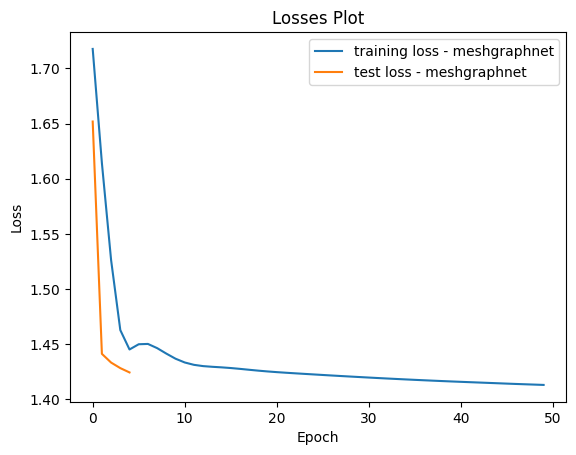

In [19]:
save_plots(args, losses, test_losses, velo_val_losses)

What happens if we train on more data? Let's test it out...

Define new parameters with a larger training set:

# Let's load model and animate flow field

With the methods below, we visualize the results from a model trained in this colab or a pre-trained model that we import from elsewhere.

In [14]:
from matplotlib import tri as mtri
from matplotlib import animation
import matplotlib.pyplot as plt
import numpy as np
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable

def make_animation(gs, pred, evl, path, name , skip = 2, save_anim = True, plot_variables = False):
    '''
    input gs is a dataloader and each entry contains attributes of many timesteps.

    '''
    print('Generating velocity fields...')
    fig, axes = plt.subplots(3, 1, figsize=(20, 16))
    num_steps = len(gs) # for a single trajectory
    num_frames = num_steps // skip
    print(num_steps)
    def animate(num):
        step = (num*skip) % num_steps
        traj = 0

        bb_min = gs[0].x[:, 0:2].min() # first two columns are velocity
        bb_max = gs[0].x[:, 0:2].max() # use max and min velocity of gs dataset at the first step for both
                                          # gs and prediction plots
        bb_min_evl = evl[0].x[:, 0:2].min()  # first two columns are velocity
        bb_max_evl = evl[0].x[:, 0:2].max()  # use max and min velocity of gs dataset at the first step for both
                                          # gs and prediction plots
        count = 0

        for ax in axes:
            ax.cla()
            ax.set_aspect('equal')
            ax.set_axis_off()

            pos = gs[step].mesh_pos
            faces = gs[step].cells
            if (count == 0):
                # ground truth
                velocity = gs[step].x[:, 0:2]
                title = 'Ground truth:'
            elif (count == 1):
                velocity = pred[step].x[:, 0:2]
                title = 'Prediction:'
            else:
                velocity = evl[step].x[:, 0:2]
                title = 'Error: (Prediction - Ground truth)'

            triang = mtri.Triangulation(pos[:, 0], pos[:, 1], faces)
            if (count <= 1):
                # absolute values

                mesh_plot = ax.tripcolor(triang, velocity[:, 0], vmin= bb_min, vmax=bb_max,  shading='flat' ) # x-velocity
                #ax.triplot(triang, 'ko-', ms=0.5, lw=0.3)
            else:
                # error: (pred - gs)/gs
                mesh_plot = ax.tripcolor(triang, velocity[:, 0], vmin= bb_min_evl, vmax=bb_max_evl, shading='flat' ) # x-velocity
                #ax.triplot(triang, 'ko-', ms=0.5, lw=0.3)
                #ax.triplot(triang, lw=0.5, color='0.5')

            ax.set_title('{} Trajectory {} Step {}'.format(title, traj, step), fontsize = '20')
            #ax.color

            #if (count == 0):
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            clb = fig.colorbar(mesh_plot, cax=cax, orientation='vertical')
            clb.ax.tick_params(labelsize=20)

            clb.ax.set_title('x velocity (m/s)',
                             fontdict = {'fontsize': 20})
            count += 1
        return fig,

    # Save animation for visualization
    if not os.path.exists(path):
        os.makedirs(path)

    if (save_anim):
        gs_anim = animation.FuncAnimation(fig, animate, frames=num_frames, interval=1000)
        writergif = animation.PillowWriter(fps=10)
        anim_path = os.path.join(path, '{}_anim.gif'.format(name))
        gs_anim.save( anim_path, writer=writergif)
        plt.show(block=True)
    else:
        pass

def visualize(loader, best_model, file_dir, args, gif_name, stats_list,
              delta_t = 0.01, skip = 1):

    best_model.eval()
    device = args.device
    viz_data = {}
    gs_data = {}
    eval_data = {}
    viz_data_loader = copy.deepcopy(loader)
    gs_data_loader = copy.deepcopy(loader)
    eval_data_loader = copy.deepcopy(loader)
    [mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y] = stats_list
    (mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y)=(mean_vec_x.to(device),
            std_vec_x.to(device),mean_vec_edge.to(device),std_vec_edge.to(device),mean_vec_y.to(device),std_vec_y.to(device))

    for data, viz_data, gs_data, eval_data in zip(loader, viz_data_loader,
                                                  gs_data_loader, eval_data_loader):
        data=data.to(args.device)
        viz_data = data.to(args.device)
        with torch.no_grad():
            pred = best_model(data,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge)

            # pred gives the learnt accelaration between two timsteps
            # next_vel = curr_vel + pred * delta_t
            viz_data.x[:, 0:2] = data.x[:, 0:2] + pred[:]* delta_t
            gs_data.x[:, 0:2] = data.x[:, 0:2] + data.y* delta_t
            # gs_data - viz_data = error_data
            eval_data.x[:, 0:2] = (viz_data.x[:, 0:2] - gs_data.x[:, 0:2])
            print(pred.shape,pred.std(dim=0),pred.mean(dim=0))
            print(data.y.shape,data.y.std(dim=0),data.y.mean(dim=0))
            print(data.x[:, 0:2].shape,data.x[:, 0:2].std(dim=0),data.x[:, 0:2].mean(dim=0))
            print()

    #print(viz_data_loader)
    make_animation(gs_data_loader, viz_data_loader, eval_data_loader, file_dir,
                      gif_name, skip, True, False)

    return eval_data_loader

First, let's implement functions for visualizing flow fields. The tricky part here is to plot all predicted flow velocity (x-velocity in this case) on a mesh. The built-in function of [tri](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.triplot.html) came into rescue. Triplot allows us to draw a unstructured triangular grid as lines, which suits our purpose perfectly.🌐

If you have been waiting through the two trainings, you can simply **skip the following cell** and just run through the visualization cell right after. ⏭

Or, if any of you would like to have a taste what the prediction would be like, we got you coverd. We have provided two trained models saved from above. You need to **load the models** first so that the animation functions will work properly.👇

Here we only review the **good one** (more data)

In [17]:
!ls ../src/best_models

model_nl6_bs16_hd4_ep50_wd0.0005_lr0.001_shuff_True_tr5_te2.csv
model_nl6_bs16_hd4_ep50_wd0.0005_lr0.001_shuff_True_tr5_te2.pt


In [19]:
# load model.
model_name = 'model_nl6_bs16_hd4_ep50_wd0.0005_lr0.001_shuff_True_tr5_te2'
args.device = torch.device('cpu') # animation function cannot work with data on GPU
num_node_features = dataset[0].x.shape[1]
num_edge_features = dataset[0].edge_attr.shape[1]
num_classes = 2 # the dynamic variables have the shape of 2 (velocity)
PATH = f"../src/best_models/{model_name}.pt"#os.path.join( checkpoint_dir, f'{model_name}.pt')
model = MeshGraphNet(num_node_features, num_edge_features, args.hidden_dim, num_classes,
                            args).to(args.device)

model.load_state_dict(torch.load(PATH, map_location=args.device))

<All keys matched successfully>

Now let's us make animations 🎥 This process might take a while depending on how many frames of velocity fields are plotted.

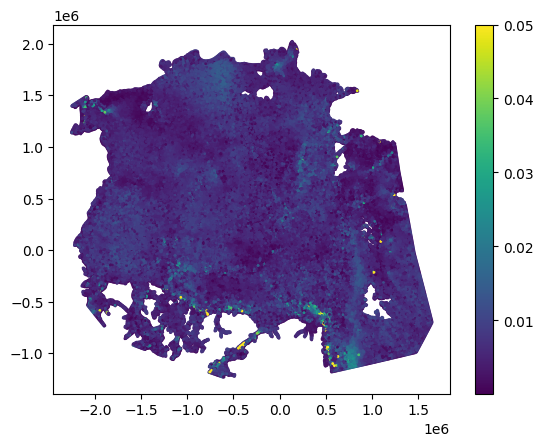

In [23]:
loader = dataset[:10]
best_model = model
delta_t = 1800

best_model.eval()
device = args.device
viz_data = {}
gs_data = {}
eval_data = {}
viz_data_loader = copy.deepcopy(loader)
gs_data_loader = copy.deepcopy(loader)
eval_data_loader = copy.deepcopy(loader)
[mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y] = stats_list
(mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y)=(mean_vec_x.to(device),
        std_vec_x.to(device),mean_vec_edge.to(device),std_vec_edge.to(device),mean_vec_y.to(device),std_vec_y.to(device))

for data, viz_data, gs_data, eval_data in zip(loader, viz_data_loader,
                                                gs_data_loader, eval_data_loader):
    data=data.to(args.device)
    viz_data = data.to(args.device)
    with torch.no_grad():
        pred = best_model(data,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge)
        pred = unnormalize(pred,mean_vec_y,std_vec_y)
        error = pred*delta_t - data.y*delta_t
        error_norm = torch.norm(error, p=2, dim=1)
        plt.scatter(data.mesh_pos[:,0],data.mesh_pos[:,1],c=error_norm,s=1,vmax=0.05)
        plt.colorbar()
        break

torch.Size([70741, 2]) tensor([1.1054e-06, 1.6853e-06]) tensor([ 6.0493e-06, -4.4250e-06])
torch.Size([70741, 2]) tensor([4.9685e-06, 5.0705e-06]) tensor([-4.0054e-08,  3.9421e-08])
torch.Size([70741, 2]) tensor([1.1054e-06, 1.6853e-06]) tensor([ 6.0493e-06, -4.4250e-06])

torch.Size([70673, 2]) tensor([1.1182e-06, 1.7074e-06]) tensor([ 6.0454e-06, -4.4147e-06])
torch.Size([70673, 2]) tensor([5.0275e-06, 5.0140e-06]) tensor([5.9097e-08, 2.1515e-07])
torch.Size([70673, 2]) tensor([1.1182e-06, 1.7074e-06]) tensor([ 6.0454e-06, -4.4147e-06])

torch.Size([70741, 2]) tensor([1.0998e-06, 1.6737e-06]) tensor([ 6.0479e-06, -4.4257e-06])
torch.Size([70741, 2]) tensor([5.0054e-06, 5.1395e-06]) tensor([ 6.2707e-08, -5.6259e-08])
torch.Size([70741, 2]) tensor([1.0998e-06, 1.6737e-06]) tensor([ 6.0479e-06, -4.4257e-06])

torch.Size([70607, 2]) tensor([1.1371e-06, 1.7433e-06]) tensor([ 6.0399e-06, -4.3961e-06])
torch.Size([70607, 2]) tensor([5.1210e-06, 4.9067e-06]) tensor([-2.2790e-07,  7.2196e-08]

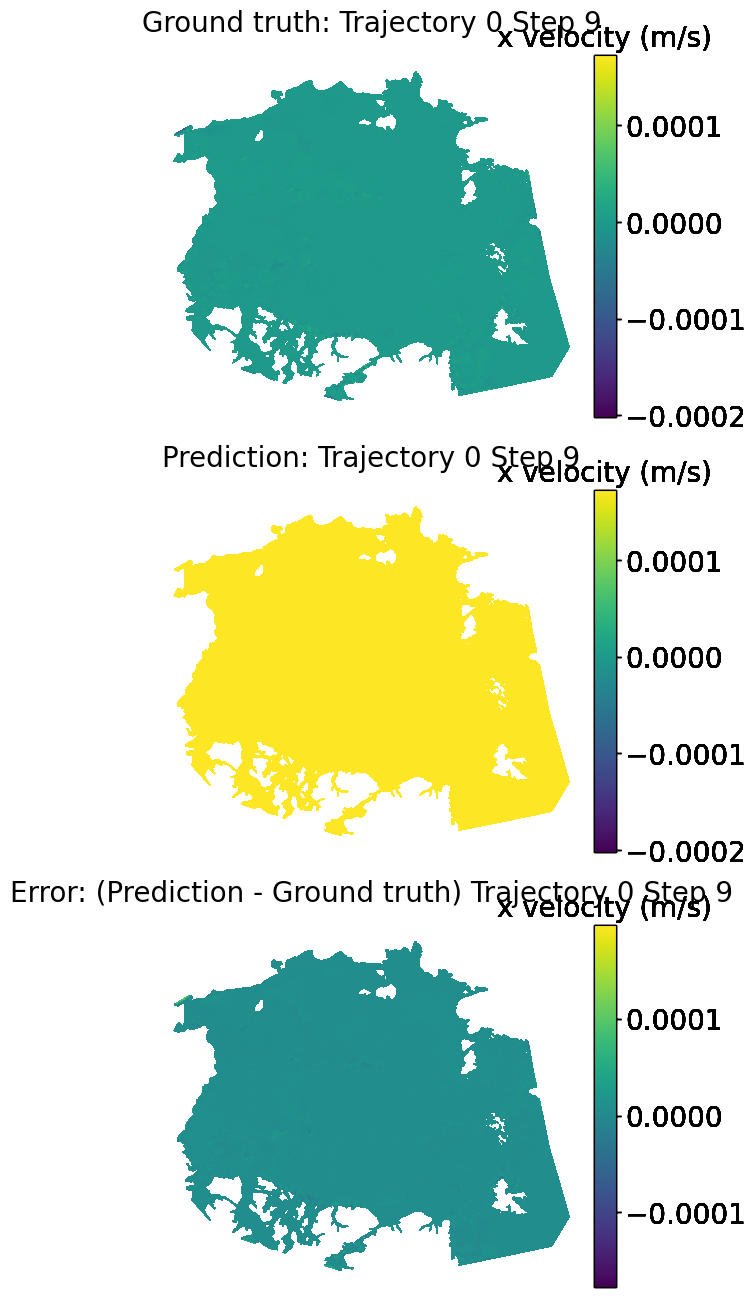

In [48]:
# visualize predicted velocities
animation_name = 'x_velocity'
args.postprocess_dir = postprocess_dir

eval_data_loader = visualize(dataset[:10], model, args.postprocess_dir, args, animation_name, stats_list,
           delta_t = 1800, skip = 1)

So now you have generated a gif named *x_velocity.gif* at the *animations* folder.  

You can download this gif file by clicking download on the *Folder* icon on the left side pannel. Then you can check offline.